In [1]:
from itertools import combinations
import numpy as np
import pandas as pd
import pickle
import copy
from tqdm import tqdm
import sys
from sklearn.model_selection import train_test_split
from torch.utils.data import (
    DataLoader, Dataset, RandomSampler, SubsetRandomSampler, Subset, SequentialSampler
)
# from HOINet import *
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import math
import copy
import pickle
import seaborn as sns
np.set_printoptions(suppress=True)

/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def combine(temp_list, n):
    temp_list2 = []
    for c in combinations(temp_list, n):
        temp_list2.append(c)
    return temp_list2

tasks = ['mort_24h',  'Long LOS', 'Readmission 30', 'Final Acuity Outcome', 'dnr_24h']
sample_list = []
for i in range(len(tasks)):
    sample_list.extend(combine(tasks, i+1))

In [3]:
# oracle search
class candidate:
    def __init__(self,task_num):
        self.performance = np.zeros((task_num))
        self.group_index = i
        self.cost = 1
def better(a, b):
    if(len(a) == 0):
        return b
    a_score = score_solution(a,a)
    b_score = score_solution(b,a)
    a_value = 0
    b_value = 0
    for i in a_score:
        a_value = a_value+i
    for i in b_score:
        b_value = b_value+i
    if(a_value > b_value):
        return a
    else:
        return b

def dominates(first, second):
    for i in range(len(first)):
        if(first[i] < second[i]):
            return False
    return True

def cfilter(candidates, best_score, budget):
    after_filter = []
    for candidate in candidates:
        if((candidate.cost <= budget) & (not dominates(best_score,candidate.performance))):
            after_filter.append(candidate)
    return after_filter

def score_solution(solution,candidates_in,size = -1):
    if(len(solution) == 0):
        score = -10000 * np.ones(len(candidates_in[0].performance),)
    else:
        score = -10000 * np.ones(len(solution[0].performance),)
    for i in solution:
        for j in range(len(solution[0].performance)):
            score[j] = max( i.performance[j], score[j] )
    return score

def get_sorting_score(running_score, a):
    amin = 1000000
    for i in range(len(running_score)):
        amin = min(amin, running_score[i]-a.performance[i])
    return amin

def get_best_networks(candidates_in, budget, running_solution):
    if(len(candidates_in) == 0):
        return running_solution
    running_score = score_solution(running_solution, candidates_in,len(candidates_in[0].performance))
    candidates = cfilter(candidates_in, running_score,budget)
    if(len(candidates) == 0):
        return running_solution
    sorted(candidates,key=lambda x:get_sorting_score(running_score, x))
    best_solution = copy.deepcopy(running_solution)
    count = 0
    while(len(candidates)!=0):
        count = count + 1
        running_solution.append( candidates[-1] )
        candidates.pop()
        best_below = copy.deepcopy(get_best_networks( candidates, budget-running_solution[-1].cost,running_solution ))
        running_solution.pop()
        best_solution = copy.deepcopy(better(best_solution, best_below))
    return best_solution

In [16]:
dataset = 'taskonomy' 
temperature = 0.00001
ratio = 'mydata'
learning_rate = 0.005
num_layers = 2
gpu_id = '0'
ensemble_num = 2
end_num= 15
num_hidden = 128
from data_util import *
from search import *
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
num = 5
lines = []
labels = []
x,y,testx,testy = getdataset(dataset,ratio)
ground_truth = y
ground_truth_mask = x
ratio = '1'
import pickle
with open('./example_log/'+dataset+'/pred_pertask_trajactiveper_1e-05_207_2_21.pkl', "rb") as fp:   
    pred_traj = pickle.load(fp)
with open('./example_log/'+dataset+'/mask_pertask_trajactiveper_1e-05_207_2_21.pkl', "rb") as fp:   
    pred_mask = pickle.load(fp)
HOApath = '/home/covpreduser/Blob/v-xiaosong/projects/MultiTaskGrouping/HOINet/gain_data/CV_results/5tasksHOA_relative.csv'
TAGpath = '/home/covpreduser/Blob/v-xiaosong/projects/MultiTaskGrouping/HOINet/gain_data/CV_5tasks/CVTAGHOA.csv'
model_pred = copy.deepcopy(np.array(pred_traj))
pred_traj = np.array(pred_traj)[[5,-1]]
total_gain_traj = []
rand_gain_traj = []
for i in range(len(pred_traj)):
    pred_cost = pred_traj[i]
    pred_cost[pred_cost == 0] = -99  
    for i in range(5):
        pred_cost[i][i] = 0
    candidate_total = []
    for k in range(len(sample_list)):
        a = candidate(len(pred_cost))
        a.performance = pred_cost[k]
        a.group_index = k
        candidate_total.append(a)
    gain_traj = []
    for iteration in range(num):
        best_solution = get_best_networks(candidate_total,iteration+1,[])
        select_gains = []
        select_index = []
        for m in best_solution:
            select_gains.append(m.performance)
            select_index.append(m.group_index)
        total_gain = 0
        selected_gr = np.array(ground_truth[select_index])
        for idx in range(len(selected_gr[0])):
            total_gain = total_gain + selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx]
            if(iteration == 4):
                print('task budget:',iteration+1,tasks[idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx],select_gains[np.argmax(np.array(select_gains)[:,idx])][idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])])
        print('MTG-Net, Sample Number',i, 'budget:',iteration+1,'\n',selected_gr,total_gain/5)
        gain_traj.append(total_gain)
    total_gain_traj.append(gain_traj)
# HOA grouping
pred_cost = pd.read_csv(HOApath,header= None , sep=' ').values
total_HOA_gain_traj = []
pred_cost[pred_cost == 0] = -99
# pred_cost = pred_cost * (-1)
candidate_total = []
for k in range(len(sample_list)):
    a = candidate(len(pred_cost))
    a.performance = pred_cost[k]
    a.group_index = k
    candidate_total.append(a)
for iteration in range(num):
    best_solution = get_best_networks(candidate_total,iteration+1,[])
    select_gains = []
    select_index = []
    for m in best_solution:
        select_gains.append(m.performance)
        select_index.append(m.group_index)
    total_gain = 0
    selected_gr = np.array(ground_truth[select_index])
    for idx in range(len(selected_gr[0])):
        total_gain = total_gain + selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx]
        if(iteration == 4):
            print('task budget:',iteration,tasks[idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx],select_gains[np.argmax(np.array(select_gains)[:,idx])][idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])])
    print('HOA, budget:',iteration,'\n',selected_gr,total_gain/5)
    total_HOA_gain_traj.append(total_gain)
# valid oracle grouping
pred_cost = copy.deepcopy(ground_truth)
oracle_gain_traj = []
pred_cost[pred_cost == 0] = -99
# pred_cost = pred_cost * (-1)
for i in range(5):
    pred_cost[i][i] = 0
candidate_total = []
for k in range(len(sample_list)):
    a = candidate(len(pred_cost))
    a.performance = pred_cost[k]
    a.group_index = k
    candidate_total.append(a)
for iteration in range(num):
    best_solution = get_best_networks(candidate_total,iteration+1,[])
    select_gains = []
    select_index = []
    for m in best_solution:
        select_gains.append(m.performance)
        select_index.append(m.group_index)
    total_gain = 0
    selected_gr = np.array(ground_truth[select_index])
    for idx in range(len(selected_gr[0])):
        total_gain = total_gain + selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx]
    oracle_gain_traj.append(total_gain)

pred_cost = copy.deepcopy(y)
valid_gain_traj = []
pred_cost[pred_cost == 0] = -99
# pred_cost = pred_cost * (-1)
for i in range(5):
    pred_cost[i][i] = 0
candidate_total = []
for k in range(len(sample_list)):
    a = candidate(len(pred_cost))
    a.performance = pred_cost[k]
    a.group_index = k
    candidate_total.append(a)
for iteration in range(num):
    best_solution = get_best_networks(candidate_total,iteration+1,[])
    select_gains = []
    select_index = []
    for m in best_solution:
        select_gains.append(m.performance)
        select_index.append(m.group_index)
    total_gain = 0
    selected_gr = np.array(ground_truth[select_index])
    for idx in range(len(selected_gr[0])):
        total_gain = total_gain + selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx]
        if(iteration == 4):
            print('task budget:',iteration,tasks[idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx],select_gains[np.argmax(np.array(select_gains)[:,idx])][idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])])
    print('Oracle, budget:',iteration,'\n',selected_gr,total_gain/5)
    valid_gain_traj.append(total_gain)

# TAG grouping
pred_cost = pd.read_csv(TAGpath,header= None , sep=' ').values
total_TAG_gain_traj = []
pred_cost[pred_cost == 0] = -99
for i in range(5):
    pred_cost[i][i] = 0
# pred_cost = pred_cost * (-1)
candidate_total = []
for k in range(len(sample_list)):
    a = candidate(len(pred_cost))
    a.performance = pred_cost[k]
    a.group_index = k
    candidate_total.append(a)
for iteration in range(num):
    best_solution = get_best_networks(candidate_total,iteration+1,[])
    select_gains = []
    select_index = []
    for m in best_solution:
        select_gains.append(m.performance)
        select_index.append(m.group_index)
    total_gain = 0
    selected_gr = np.array(ground_truth[select_index])
    for idx in range(len(selected_gr[0])):
        total_gain = total_gain + selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx]
        if(iteration == 4):
            print('task budget:',iteration,tasks[idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])][idx],select_gains[np.argmax(np.array(select_gains)[:,idx])][idx],selected_gr[np.argmax(np.array(select_gains)[:,idx])])
    print('TAG, budget:',iteration,'\n',selected_gr,total_gain/5)
    total_TAG_gain_traj.append(total_gain)
# Random
total_traj = []
validy = y
validx = x
for iteration in range(100):
    # print(iteration)
    rand_traj = []
    for num_ in range(1,6):
        while(True):
            rand_sample = np.random.choice(np.arange(len(x)) ,size = num_,replace = False )
            a = np.zeros((len(x[0])),)
            for i in x[rand_sample]:
                a = a+i
            if(len(a[a==0])==0 ):
                value = np.zeros((len(x[0])))
                selected = validy[rand_sample]
                test = testy[rand_sample]
                testmask = testx[rand_sample]
                for i in range(len(y[0])):
                    value[i] = test[np.argmax(selected[:,i])][i]
                break
        rand_traj.append(value.sum())
    total_traj.append(np.array(rand_traj))

for i in range(len(total_gain_traj)):
    for j in range(len(total_gain_traj[i])):
        if(total_gain_traj[i][j] > valid_gain_traj[j]):
            total_gain_traj[i][j] = valid_gain_traj[j]
NN_gain1 = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(total_gain_traj[0])/5  })
NN_gain2 = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(total_gain_traj[1])/5  })
HOA_gain = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(total_HOA_gain_traj)/5  })
valid_gain = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(valid_gain_traj)/5  })
oracle_gain = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(oracle_gain_traj)/5  })
rand_gain = pd.DataFrame({'budget':list(range(1,len(total_gain_traj[0])+1)),'Average Gain': np.array(total_traj).mean(0)/5})
TAG_gain = pd.DataFrame({'budget':list(range(1,len(total_TAG_gain_traj)+1)),'Average Gain': np.array(total_TAG_gain_traj)/5})
HOA_gain['type'] = 'HOA gain'
NN_gain1['type'] = 'MTG-Net K=1'
NN_gain2['type'] = 'MTG-Net K=2'
rand_gain['type'] = 'Random'
TAG_gain['type'] = 'TAG'
oracle_gain['type'] = 'Ground truth'
valid_gain['type'] = 'Oracle'
all_gain = pd.concat([valid_gain,NN_gain2,NN_gain1,HOA_gain,TAG_gain,rand_gain],axis=0)

load 5tasks
MTG-Net, Sample Number 4 budget: 0 
 [[ 0.13827  0.08804 -0.02833 -0.07699  0.05248]] 0.034694
MTG-Net, Sample Number 4 budget: 1 
 [[ 0.13827  0.08804 -0.02833 -0.07699  0.05248]
 [ 0.       0.13844 -0.00237  0.2089   0.     ]] 0.10714399999999999
MTG-Net, Sample Number 4 budget: 2 
 [[ 0.13827  0.08804 -0.02833 -0.07699  0.05248]
 [ 0.       0.11688  0.01805  0.       0.11046]
 [ 0.       0.13844 -0.00237  0.2089   0.     ]] 0.122824
MTG-Net, Sample Number 4 budget: 3 
 [[ 0.13827  0.08804 -0.02833 -0.07699  0.05248]
 [ 0.       0.11688  0.01805  0.       0.11046]
 [ 0.       0.13844 -0.00237  0.2089   0.     ]
 [ 0.       0.14612  0.0083   0.       0.     ]] 0.12436
task budget: 4 mort_24h 0.13827 0.13827 [ 0.13827  0.08804 -0.02833 -0.07699  0.05248]
task budget: 4 Long LOS 0.14612 0.14612 [0.      0.14612 0.0083  0.      0.     ]
task budget: 4 Readmission 30 0.01805 0.01805 [0.      0.11688 0.01805 0.      0.11046]
task budget: 4 Final Acuity Outcome 0.2089 0.2089 [ 0

/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbedcc22d30> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbedcc22fd0> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbedcc22048> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbedcc22c88> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipyker

load 5tasks


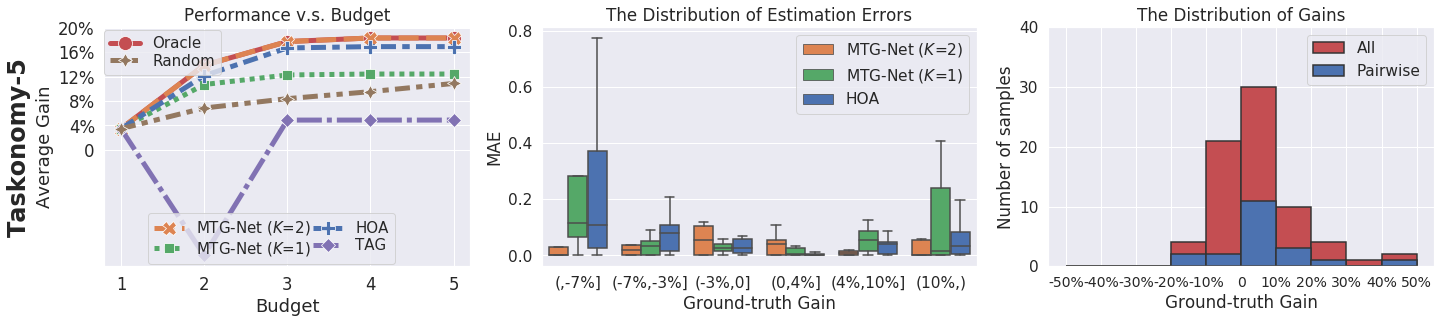

In [11]:
HOA_gain['type'] = 'HOA'
valid_gain['type'] = 'Oracle'
NN_gain1['type'] = 'MTG-Net ($K$=1)'
NN_gain2['type'] = 'MTG-Net ($K$=2)'
all_gain = pd.concat([valid_gain,NN_gain2,NN_gain1,HOA_gain,TAG_gain,rand_gain],axis=0)
gs = gridspec.GridSpec(2, 140)
plt.figure(figsize=(24.9,4.4))
ax_title = plt.subplot(gs[:,:6])
ax_title.grid(False)
ax_title.set_facecolor('white')
ax_title.set_xticklabels([])
ax_title.set_ylabel('Taskonomy-5',fontsize=24,fontweight="bold")
ax_title.set_yticklabels([])
mypalette = [sns.color_palette()[3],sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0],sns.color_palette()[4],sns.color_palette()[5]]
ax1 = plt.subplot(gs[:,6:43])
# plt.figure(figsize=(20,4))
sns.set(font_scale=1.4)
sns.lineplot(x="budget", y="Average Gain",hue="type",palette = mypalette,style='type', markers=True,linewidth = 5,markersize=14, data=all_gain,ax = ax1)
# plt.subplots_adjust(right=0.8)
ax1.set_xlabel('Budget')
l1 = ax1.legend(['Oracle','_','_','_','_','Random'],ncol = 1,loc='lower left',bbox_to_anchor=(-0.02,0.77),fontsize=15,columnspacing=0.15,labelspacing=0.15)
ax1.add_artist(l1)
ax1.legend(['_','MTG-Net ($K$=2)','MTG-Net ($K$=1)','HOA','TAG'],ncol = 2,loc='lower left',bbox_to_anchor=(0.1,-0.02),fontsize=15,columnspacing=0.15,labelspacing=0.15)
# ax1.legend(['Oracle','HOA','TAG','Random','MTG-Net $K$=13','MTG-Net $K$=1'],ncol = 3,bbox_to_anchor=(0.5,-0.02),fontsize=14,loc=8,columnspacing=0.1,labelspacing=0.1)
ax1.set_xticks([1,2,3,4,5])
ax1.set_yticks([0,0.04,0.08,0.12,0.16,0.20])
ax1.set_yticklabels(['0','4%','8%','12%','16%','20%'])
ax1.set_xticks([1,2,3,4,5])
# plt.ylim(0,0.08)
if(ratio == 'smalldata'):
    ax1.set_title('Performance v.s. Budget for MTG-Net')
else:
    ax1.set_title('Performance v.s. Budget')

ax2 = plt.subplot(gs[:,101:147])
plt.title('The Distribution of Gains')
x,y,testx,testy = getdataset(dataset,ratio)
if(ratio == 'mydata'):
    HOApath = '/home/covpreduser/Blob/v-xiaosong/projects/MultiTaskGrouping/HOINet/gain_data/CV_results/5tasksHOA_relative.csv'
else:
    HOApath = '/home/covpreduser/Blob/v-xiaosong/projects/MultiTaskGrouping/HOINet/gain_data/CV_results/mysmallHOA_relative.csv'
HOA = np.array(pd.read_csv(HOApath,header = None,sep=' '))
import copy
y_n2 = y
P_n2 = HOA
ground_truth = y
range0 = np.percentile(y[y<0],0)
range1 = np.percentile(y[y<0],33)
range2 = np.percentile(y[y<0],66)
range3 = 0
range4 = np.percentile(y[y>0],33)
range5 = np.percentile(y[y>0],66)
range6 = np.percentile(y[y>0],100)
boxplot_x = np.array([range0,range1,range2,range3,range4,range5,range6])
num_list = np.array([0.00,0.005,0.01,0.015])
# num_list1 = [1,2,3,1]
total_width, n = 0.001, 2
width = total_width
num_list1 = num_list- width
if(ratio == 'smalldata'):
    bin_sel = np.array(list(range(-20,30,5)))*0.001
    plt.ylim(0,14)
else:
    bin_sel = np.array(list(range(-500,600,100)))*0.001
total_y = testy
y_train = y
# ???
total_output = copy.deepcopy(model_pred)[-1]
name_list = ['-50%','-40%','-30%','-20%','-10%','0','10%','20%','30%','40%','50%']
plt.xticks(bin_sel,name_list,fontsize=14)
plt.hist(y[y!=0], bins=bin_sel, normed=0, color=sns.color_palette()[3],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='All', alpha=1)
plt.hist(y[5:15][y[5:15]!=0], bins=bin_sel, normed=0, color=sns.color_palette()[0],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='Pairwise', alpha=1)
plt.xlabel('Ground-truth Gain')
plt.ylabel('Number of samples')
plt.ylim(0,40)
plt.legend()


average_boxplot = []
name_list = ['(,-7%]','(-7%,-3%]','(-3%,0]','(0,4%]','(4%,10%]','(10%,)']
for i in range(len(boxplot_x)-1):
    average_boxplot.append(abs(P_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] - y_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] ))
average_boxplot[0][average_boxplot[0]>0.6] = average_boxplot[0][average_boxplot[0]>0.6]
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ))
import pandas as pd
type_column = []
MAE_column = []
Range_column = []
for i in range(len(name_list)):
    for j in average_boxplot[i]:
        type_column.append('HOA')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_average = pd.DataFrame(data = df_set)
import pandas as pd
type_column = []
MAE_column = []
Range_column = []
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        type_column.append('MTG-Net ($K$=2)')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_NN1 = pd.DataFrame(data = df_set)


total_output = copy.deepcopy(model_pred)[-5]
ycopy = copy.deepcopy(y[y!=0])
boxplot_x[-1] = boxplot_x[-1]
count = 10
plt.legend()
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ))
import pandas as pd
type_column = []
MAE_column = []
Range_column = []
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        type_column.append('MTG-Net ($K$=1)')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_NN2 = pd.DataFrame(data = df_set)
all_average = pd.concat([df_NN1,df_NN2,df_average],axis=0)
ax3 = plt.subplot(gs[:,50:94])
sns.boxplot(x="Range", y="MAE",
                hue="type",
                data=all_average,showfliers = False,saturation=1,palette = (sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0]))
                # ,
                # ax=ax3
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles[0:], labels=labels[0:])
plt.xlabel('Ground-truth Gain')
plt.title('The Distribution of Estimation Errors')
plt.show()